# AutoRec

- [AutoRec: Autoencoders Meet Collaborative Filtering](http://users.cecs.anu.edu.au/~u5098633/papers/www15.pdf)

## Experiment

- I-AutoRec has higher performance than U-AutoRec
- Optimizer: Adamax
    - Adamax has the highest performance over the other optimizers
    - Adamax > SGD > Adam > RMSprop
- L2 regularization with 0.0001
    - Less strict regularization makes the model flexible
- This experiment was conducted using Google Colab

## Problems

- Too sensitive to data splitting
    - Suggest to use ML-10M for robust model
- Item based profile consumes too much RAM

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''
    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

5922816/5917549 [==============================] - 1s 0us/step
(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(n_user)

6040


In [5]:
idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(n_item)

3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = Id2idx(ratings)
ratings.head(5)

,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


In [8]:
def make_interaction(df: pd.DataFrame, user_based = True) -> pd.DataFrame:
    if user_based:
        return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)
    else:
        return df.groupby('movieId', as_index = False)[['userId', 'rating']].agg(list)

In [9]:
def data_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train, test = train_test_split(df, test_size = 0.1, random_state = 7777)
    train, valid = train_test_split(train, test_size = 0.1, random_state = 7777)
    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    return train, valid, test

In [10]:
def make_generator(df: pd.DataFrame, 
                   n_user: int, 
                   n_item: int, 
                   batch_size: int, 
                   user_based = True, 
                   implicit = False, 
                   threshold = 3.5) -> Tuple[np.array, np.array]:

    n_row = df.index.size
    n_col = n_item if user_based else n_user

    Ids = np.arange(n_row)
    profiles = df['movieId'] if user_based else df['userId']
    ratings = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):         
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                batch[i, profiles[idx]] = ratings[idx]
            
            yield batch, batch

In [11]:
def masked_mse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    return K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)

def masked_rmse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)

def masked_rmse_clip(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    y_pred = K.clip(y_pred, 0, 5)
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)

In [12]:
def AutoRec(n_user: int, 
            n_item: int, 
            user_based = True, 
            latent_dim = 500,
            first_activation = 'sigmoid', 
            last_activation = 'linear',
            optimizer = 'nadam', 
            learning_rate = 0.001,
            kernel_initializer = None,
            kernel_regularizer = None) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
        
    input_shape = n_item if user_based else n_user

    inputs = Input(shape = (input_shape, ), name = 'input')
    latents = Dense(latent_dim, activation = first_activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(inputs)
    outputs = Dense(input_shape, activation = last_activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(latents)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = optimizer, loss = masked_mse, metrics = [masked_rmse, masked_rmse_clip])
    return model

In [13]:
def make_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_user: int, 
                   n_item: int, 
                   batch_size: int, 
                   user_based = True, 
                   implicit = False, 
                   threshold = 3.5) -> float:

    n_row = df.index.size
    n_col = n_item if user_based else n_user

    Ids = np.arange(n_row)
    profiles = df['movieId'] if user_based else df['userId']
    ratings = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    res: float = 0.0
    N: int = 0
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profiles[idx]] = ratings[idx]

        y_pred = model.predict(y_true, verbose = 0)

        res += np.sum(masked_rmse(y_true, y_pred).numpy())
        N += batch_Id.size
    return res / N

In [14]:
def show_history(hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history['masked_rmse'])
    ax2.plot(hist.history['val_masked_rmse'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['masked_rmse', 'val_masked_rmse'], loc = 'upper right')
    plt.show()

## 2. U-AutoRec

In [15]:
epochs = 500
batch_size = 128

user_profile = make_interaction(ratings, user_based = True)
train, valid, test = data_split(user_profile)
train_gen, valid_gen = map(lambda x: make_generator(x, n_user, n_item, batch_size, user_based = True), (train, valid))

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid.index.size // batch_size + 1

In [16]:
# lr_schedule = ExponentialDecay(initial_learning_rate = 0.002, decay_steps = 10, decay_rate = 0.96, staircase = True)
# optimizer = RMSprop(learning_rate = lr_schedule)
# optimizer = SGD(lr = 0.1, decay = 1e-5, momentum = 0.9, nesterov = True)
model = AutoRec(n_user, n_item, optimizer = 'adamax')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
encoder (Dense)              (None, 500)               1853500   
_________________________________________________________________
decoder (Dense)              (None, 3706)              1856706   
Total params: 3,710,206
Trainable params: 3,710,206
Non-trainable params: 0
_________________________________________________________________


In [17]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('U-AutoRec_1M.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
39/39 [==============================] - 1s 33ms/step - loss: 4.6677 - masked_rmse: 1.7559 - masked_rmse_clip: 1.7205 - val_loss: 2.0742 - val_masked_rmse: 1.0891 - val_masked_rmse_clip: 1.0811
Epoch 2/500
39/39 [==============================] - 1s 28ms/step - loss: 1.9664 - masked_rmse: 1.0488 - masked_rmse_clip: 1.0467 - val_loss: 1.8859 - val_masked_rmse: 1.0196 - val_masked_rmse_clip: 1.0188
Epoch 3/500
39/39 [==============================] - 1s 32ms/step - loss: 1.8301 - masked_rmse: 1.0002 - masked_rmse_clip: 0.9999 - val_loss: 1.8105 - val_masked_rmse: 0.9959 - val_masked_rmse_clip: 0.9957
Epoch 4/500
39/39 [==============================] - 1s 31ms/step - loss: 1.7538 - masked_rmse: 0.9767 - masked_rmse_clip: 0.9766 - val_loss: 1.7789 - val_masked_rmse: 0.9940 - val_masked_rmse_clip: 0.9938
Epoch 5/500
39/39 [==============================] - 1s 30ms/step - loss: 1.6968 - masked_rmse: 0.9608 - masked_rmse_clip: 0.9608 - val_loss: 1.7333 - val_masked_rmse: 0.9823 -

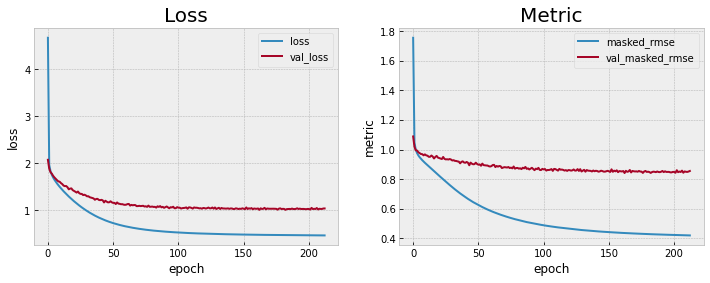

In [18]:
show_history(hist)

In [19]:
test_pred = make_predictor(test, model, n_user, n_item, batch_size, user_based = True)
print(f'Mean of masked RMSE: {test_pred:.4f}')

Mean of masked RMSE: 0.8581


## 3. I-AutoRec

In [20]:
epochs = 500
batch_size = 128

item_profile = make_interaction(ratings, user_based = False)
train, valid, test = data_split(item_profile)
train_gen, valid_gen = map(lambda x: make_generator(x, n_user, n_item, batch_size, user_based = False), (train, valid))

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = test.index.size // batch_size + 1

In [21]:
model = AutoRec(n_user, n_item, optimizer = 'adamax', user_based = False)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6040)]            0         
_________________________________________________________________
encoder (Dense)              (None, 500)               3020500   
_________________________________________________________________
decoder (Dense)              (None, 6040)              3026040   
Total params: 6,046,540
Trainable params: 6,046,540
Non-trainable params: 0
_________________________________________________________________


In [22]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('I-AutoRec_1M.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
24/24 [==============================] - 1s 42ms/step - loss: 6.1577 - masked_rmse: 2.0070 - masked_rmse_clip: 1.9713 - val_loss: 3.2714 - val_masked_rmse: 1.2978 - val_masked_rmse_clip: 1.2917
Epoch 2/500
24/24 [==============================] - 1s 34ms/step - loss: 2.9455 - masked_rmse: 1.1838 - masked_rmse_clip: 1.1799 - val_loss: 2.8104 - val_masked_rmse: 1.1233 - val_masked_rmse_clip: 1.1220
Epoch 3/500
24/24 [==============================] - 2s 87ms/step - loss: 2.5827 - masked_rmse: 1.0520 - masked_rmse_clip: 1.0507 - val_loss: 2.5226 - val_masked_rmse: 1.0292 - val_masked_rmse_clip: 1.0283
Epoch 4/500
24/24 [==============================] - 2s 83ms/step - loss: 2.4224 - masked_rmse: 1.0002 - masked_rmse_clip: 0.9991 - val_loss: 2.4827 - val_masked_rmse: 1.0308 - val_masked_rmse_clip: 1.0301
Epoch 5/500
24/24 [==============================] - 1s 38ms/step - loss: 2.3092 - masked_rmse: 0.9660 - masked_rmse_clip: 0.9650 - val_loss: 2.3988 - val_masked_rmse: 1.0117 -

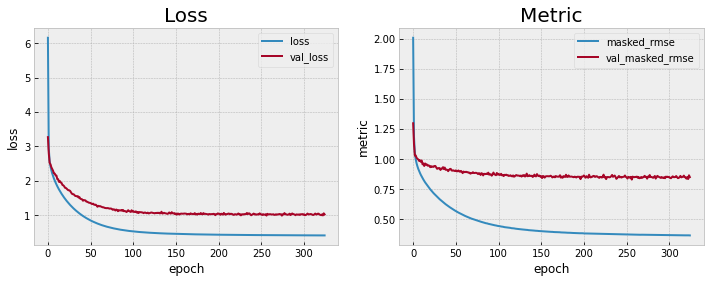

In [23]:
show_history(hist)

In [24]:
test_pred = make_predictor(test, model, n_user, n_item, batch_size, user_based = False)
print(f'Mean of masked RMSE: {test_pred:.4f}')

Mean of masked RMSE: 0.8269
